In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.eval import calculate_rouge, calculate_f1_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/squad/test.csv")

scores = json.load(open("results/t5/checkpoint-26280_squad_scores.json", "r"))
with open("results/t5/checkpoint-26280_squad_sentences") as file:
    texts = [line.rstrip() for line in file]

In [3]:
rougels, f1s = list[float](), list[float]()
for pred, label in zip(texts, df["target"]):
    rouge = calculate_rouge(predictions=[pred], references=[[label]])["rougeL"]
    f1 = calculate_f1_score(prediction=pred, ground_truth=label)
    rougels.append(rouge)
    f1s.append(f1)

In [4]:
df_score = pd.DataFrame(
    {
        "rougel": rougels,
        "f1": f1s,
        "cert": scores["99"],
    }
)

In [5]:
np.corrcoef(df_score["rougel"], df_score["cert"])

array([[1.        , 0.33466599],
       [0.33466599, 1.        ]])

In [6]:
np.corrcoef(df_score["f1"], df_score["cert"])

array([[1.        , 0.32557822],
       [0.32557822, 1.        ]])

Text(0.5, 1.0, 'HotpotQA')

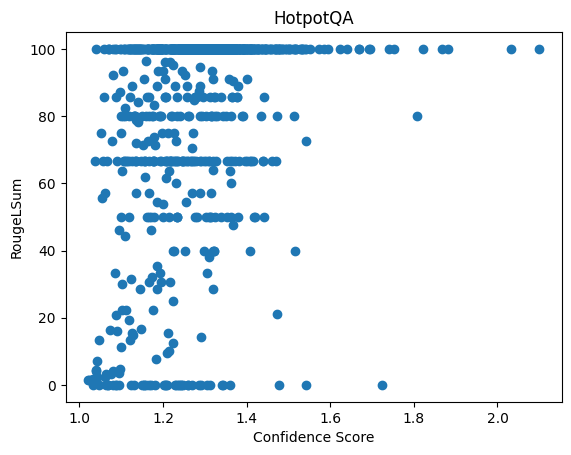

In [7]:
plt.scatter(y=df_score["rougel"], x=df_score["cert"])
plt.xlabel("Confidence Score")
plt.ylabel("RougeLSum")
plt.title("HotpotQA")

Text(0.5, 1.0, 'SQUAD')

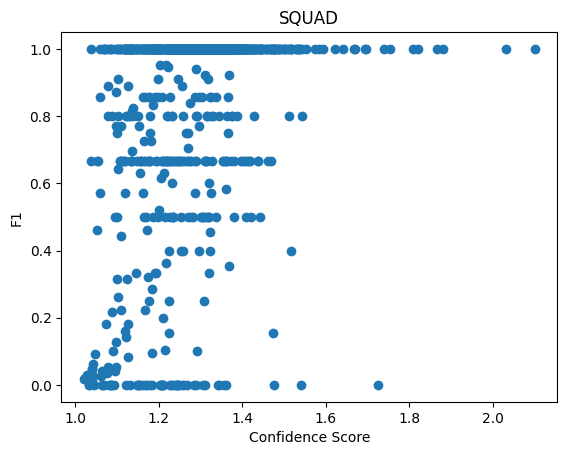

In [8]:
plt.scatter(y=df_score["f1"], x=df_score["cert"])
plt.xlabel("Confidence Score")
plt.ylabel("F1")
plt.title("SQUAD")

/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'SQUAD')

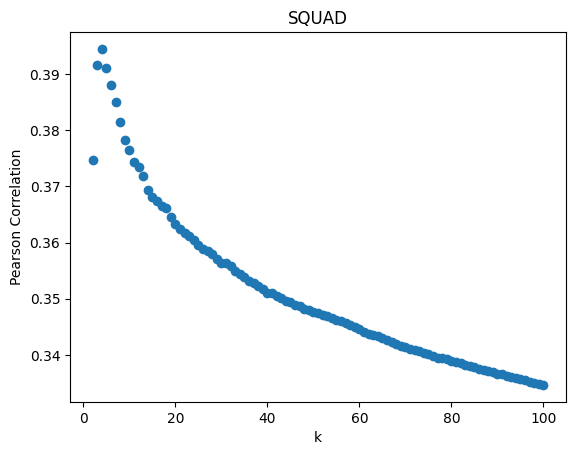

In [9]:
correlations = [
    np.corrcoef(df_score["rougel"], scores[str(k)])[0, 1] for k in range(100)
]
plt.scatter(x=list(range(1, 101)), y=correlations)
plt.xlabel("k")
plt.ylabel("Pearson Correlation")
plt.title("SQUAD")